В данном ноутбуке рассматривается технология вариационных автокодировщиков (Variative Auto Encoder - VAL)

Основная идея генерации изображений заключается с создании малоразмерного пространства представлений, каждая точка которого может быть проецирована в реалистичное изображение.

VAL хорошо подходят как раз для создание суперструктурированного пространства представлений

Рассмотрим понятие "концептуальный вектор". Пусть у нас есть вектор s ("smile") и некоторая точка z, соответствующая лицу человека. Тогда точка z + s будет соответствовать улыбающимуся лицу. То есть это некоторое направление в пространстве представлений, которое кодирует значимые изменения в изображении.
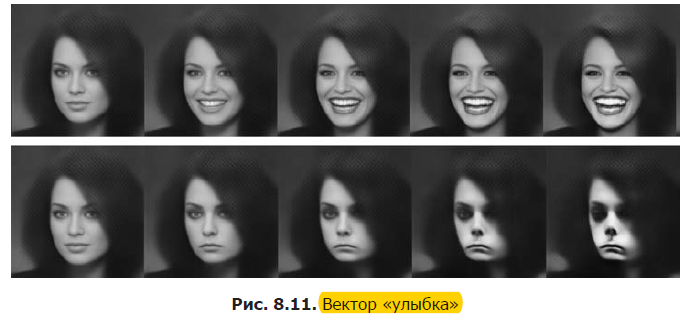

Классический кодироващик берет изображение, кодирует его в пространство представлений (кодером), затем декодирует в изображение' (другое)(декодером). Кодировщики обучаются для того, чтобы изображение' = изображение. Такие кодировщики не могут создать хорошо структурированное пространство представлений.
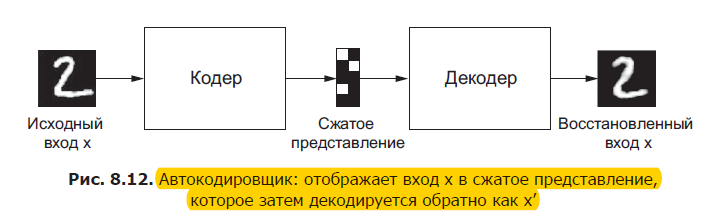

Вариационный автокодировщик берет изображение, представляет его в виде параметров статистического распределения: среднего и дисперсии. Затем из нормального распределения элементов берется один элемент и декодер по этим параметрам создает из него изображение, крайне похожее не оригинальное.
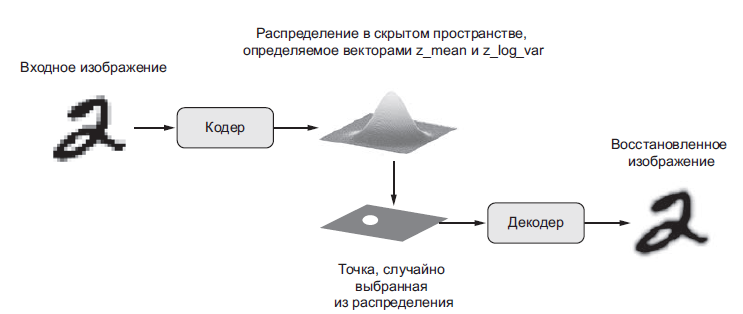

Пространство представлений, полученное с помощью вариационного автокодировщика имеет маленький размер. Две точки, находящиеся рядом в этом пространстве отобразятся в очень похожие изображения. Значит, в этом пространстве можно наблюдать последовательности точек, каждая из которых находится близко в предыдущей, которые отобразяться в похожие изображения - это и есть концептуальные векторы.



VAL обучается на двух функциях потерь:
* Потери реконструкции - совпадение генерируемых и исходных данных
* Потери регуляризации - решение проблемы переобучения и создание хорошо структурированного пространства представлений

Схематически весь процесс выглядит так:
* z_mean, z_log_variance = encoder(input_img) - кодирование изображения
* z = z_mean + exp(z_log_variance) * epsilon - выбор случайной точки
* reconstructed_img = decoder(z) - декодирование изображения
* model = Model(input_img, reconstructed_img) - создание модели, которая отображаетвходное изображение в его реконструкцию


# Пример сети, превращающей изображение в два параметра - среднее и дисперсию

In [2]:
import keras
import tensorflow as tf
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np
tf.compat.v1.disable_eager_execution()

img_shape = (28, 28, 1)
batch_size = 16
# размерность скрытого пространства
dimensions =  2

input_img = keras.Input(shape=img_shape)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(dimensions)(x)
z_log_var = layers.Dense(dimensions)(x)



Выбор точки скрытого пространства представлений

In [3]:
def get_point(args):
  z_mean, z_log_var = args
  # нормальное распределение
  epsilon = K.random_normal(shape=(K.shape(z_mean)[0], dimensions), mean=0., stddev=1.)
  return z_mean + K.exp(z_log_var) * epsilon

# в Keras ВСЕ нужно помещать в слои
# поэтому даже функию нужно поместить в специальный слой Lambda
z = layers.Lambda(get_point)([z_mean, z_log_var])

Сеть декодера VAE. отображающая точки из пространства признаков в изображения

In [4]:
decoder_input = layers.Input(K.int_shape(z)[1:])

# увеличение разрешения входа
# делаем z той же размерности, что и целевое изображение
x = layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
# преобразование z в карту призаков с той же формой, которая была у изображения пере 
# слоем Flatten в кодировщике
x = layers.Reshape(shape_before_flattening[1:])(x)
# декодирование z  в карту признаков
x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)

# общая модель декодера
decoder = Model(decoder_input, x)
# декордер конкретно для z
z_decoded = decoder(z)

В VAE потери имеют двойственную структуру, что не является стандартным loss(input, target). Напишем свой класс для вычисления потерь

In [5]:
class CustomVariationalLayer(keras.layers.Layer):

  # вычисление случайной потери
  def vae_loss(self, x, z_decoded):
    x = K.flatten(x)
    z_decoded = K.flatten(z_decoded)
    # темная магия...
    xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
    kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)
  
  # добавление случайной составляющей потери
  def call(self, inputs):
    x = inputs[0]
    z_decoded = inputs[1]
    loss = self.vae_loss(x, z_decoded)
    # add_loss встроенный в layers.Layer метод
    self.add_loss(loss, inputs=inputs)
    # не используется, просто нужно, чтобы что-то возвращало
    return x

# вызов слоя с исходными и декодированными данными для получения окончательного
# вывода модели
y = CustomVariationalLayer()([input_img, z_decoded])

# Создание и обучение модели VAE

In [6]:
from keras.datasets import mnist

# input_img и y ранее определены
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(
    x=x_train,
    # потери вычисляются отдельным классом, это означает, что нет смысла
    # передавать сюда целевые данные для тренировки
    y=None,
    shuffle=True,
    epochs=10,
    batch_size=batch_size,
    validation_data=(x_test, None)
)

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_1[0][0]                   
_______________________________________________________________________________________

После обучения можно использовать decoder для получения изображений

# Выбор сетки точек из пространства представлений и декодирование их в изображения

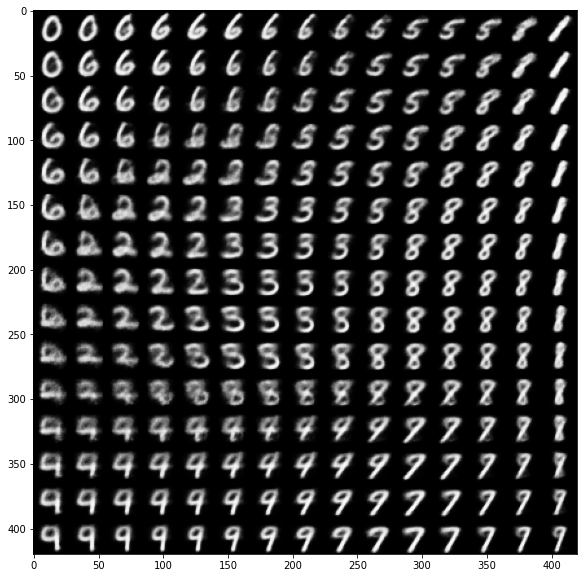

In [7]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np

# будет отображаться сетка 15x15 (225 цифр)
n = 15
digit_size = 28
# поле для отображения
figure = np.zeros((digit_size * n, digit_size * n))
# Преобразует координаты линей-ного пространства с использова-нием функции ppf 
# из пакета SciPy для получения значений скрытой переменной z 
# (поскольку пред-шествующее скрытое простран-ство является гауссовым)
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
  for j, xi in enumerate(grid_y):
    z_sample = np.array([[xi, yi]])
    # многократное повторение выбора z для деформирования полного пакета
    z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
    # декодирование пакета в изображение цифр
    x_decoded = decoder.predict(z_sample, batch_size=batch_size)
    digit = x_decoded[0].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()